In [1]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import matplotlib.pyplot as plt
import glob
import os
import geopandas as gpd

from shapely.geometry import Polygon
from shapely.geometry import mapping

from atlite.gis import ExclusionContainer, shape_availability

In [2]:
tiff_paths = [
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/euro_slope_40degs.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/airport_airports_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/powerlines_powerlines_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/rail_narrow_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/glacier_glacier_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_motorway_link_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/military_military_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/radar_radar_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/2000m.tif'
    #'/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_primary_primary_buffered.tif',
]

In [3]:
src_files_to_mosaic = []

for fp in tiff_paths:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)
    
# Merge the raster files
mosaic, out_transform = merge(src_files_to_mosaic)

# Close the file connections
for src in src_files_to_mosaic:
    src.close()

# Define the output file path
output_file = '/home/oskar/shared_input/geodata/onshore/wimby/processed/technical_exclusions.tif'

# Copy the metadata from one of the original files
out_meta = src.meta.copy()

# Update the metadata to match the merged data
out_meta.update({
    'driver': 'GTiff',
    'height': mosaic.shape[1],
    'width': mosaic.shape[2],
    'transform': out_transform,
    'count': mosaic.shape[0],
    'compress': 'lzw'  # Adding LZW compression
})

# Write the merged file
with rasterio.open(output_file, "w", **out_meta) as dest:
    dest.write(mosaic)


In [4]:
def plot_eligible_area(ax, tiff_path, europe, title):
    excluder_wind_onshore = ExclusionContainer()

    # Ensuring the correct CRS for full_europe
    full_europe = (
        europe
        .assign(col='a')
        .dissolve(by='col')
        .geometry
    )

    # Open the TIFF file and ensure CRS matches
    with rasterio.open(tiff_path) as src:
        if full_europe.crs != src.crs:
            full_europe = full_europe.to_crs(src.crs)

    # Bufffer geometry ensuring CRS consistency
    full_europe = full_europe.to_crs(excluder_wind_onshore.crs)

    # Example mask and transformation logic
    excluder_wind_onshore.add_raster(tiff_path)
    masked, transform = shape_availability(full_europe, excluder_wind_onshore)
    eligible_share = (masked.sum() * excluder_wind_onshore.res**2 / full_europe.geometry.item().area)
    
    # Plot the eligible area in a subplot
    show(masked, transform=transform, cmap='Greens', ax=ax)
    full_europe.plot(ax=ax, edgecolor='k', color='None')
    europe.to_crs(excluder_wind_onshore.crs).boundary.plot(ax=ax, edgecolor='grey', linewidth=0.2)
    ax.set_title(f'{title} Eligible area (green) {eligible_share * 100:2.2f}%')

In [5]:
aggregated_regions = [
    "AT", "BE", "BG", "CH", "CZ", "DE",
    "DK", "EE", "ES", "FI", "FR", "UK",
    "GR", "HR", "HU", "IE", "IT", "LT",
    "LU", "LV", "NL", "NO", "PL", "PT", 
    "RO", "SE", "SI", "SK",
]

In [6]:
europe = (
    gpd
    .read_file('/home/oskar/shared_input/geodata/onshore/shapes/NUTS_RG_10M_2021_4326.geojson')
    .query("NUTS_ID == @aggregated_regions")
    .set_index(["NUTS_ID"])
    .loc[:,['geometry']]
)

In [7]:
# The square outer boundaries of Europe to consider, because we have downloaded ERA5 for this extent:
rectx1 = -12
rectx2 = 44
recty1 = 33
recty2 = 72

In [8]:
polygon = Polygon(
    [
        (rectx1, recty1),
        (rectx1, recty2),
        (rectx2, recty2),
        (rectx2, recty1),
        (rectx1, recty1),
    ]
)
europe = gpd.clip(europe, polygon)

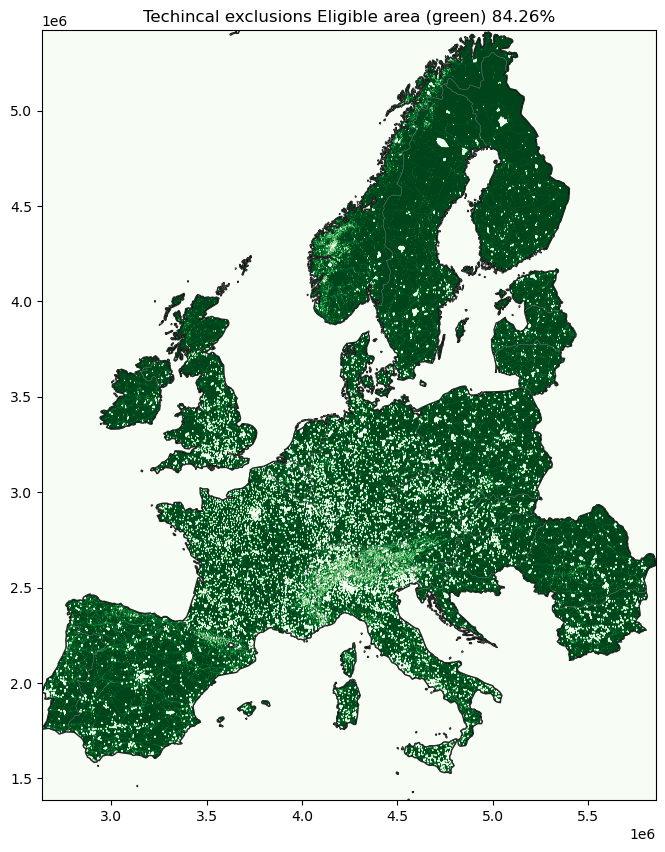

In [9]:
fig, ax = plt.subplots(1,1,figsize=(16,10))

plot_eligible_area(ax, '/home/oskar/shared_input/geodata/onshore/wimby/processed/technical_exclusions.tif', europe, 'Techincal exclusions')